In [13]:
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#import pyemma
from shapeGMM import gmm_shapes
from shapeGMMTorch import torch_sgmm
from shapeGMMTorch import scripts
import MDAnalysis as md
import torch
import pickle

In [14]:
# read trajectory data
data_path = "/scratch/projects/hockygroup/ss12902/posLDA_actin/cluster_opes_data_from_triasha/run_with_v1.6.1/run_with_1us_data"
atoms_selection = "name CA"
print("selected atoms:", atoms_selection)

# load data
prmtopFileName =  data_path + "/s1_init_protein_only.gro"
trajFiles = [data_path+"/opes_ld1_bf_12.0_barrier_15.0_wrapped_protein_only.trr"]
print(trajFiles)
print(len(trajFiles))

coord = md.Universe(prmtopFileName,trajFiles)
sel_atoms = coord.select_atoms(atoms_selection)
print("Number of atoms in trajectory:", coord.atoms.n_atoms)
print("Number of frames in trajectory:",coord.trajectory.n_frames)
print("Number of atoms being analyzed:",sel_atoms.n_atoms)
print("Number of frames being analyzed:",coord.trajectory.n_frames)

trajData = np.empty((coord.trajectory.n_frames,sel_atoms.n_atoms,3),dtype=float)
count = 0

for ts in coord.trajectory:
    trajData[count,:,:] = sel_atoms.positions - sel_atoms.center_of_geometry()
    count += 1

selected atoms: name CA
['/scratch/projects/hockygroup/ss12902/posLDA_actin/cluster_opes_data_from_triasha/run_with_v1.6.1/run_with_1us_data/opes_ld1_bf_12.0_barrier_15.0_wrapped_protein_only.trr']
1
Number of atoms in trajectory: 5835
Number of frames in trajectory: 21001
Number of atoms being analyzed: 375
Number of frames being analyzed: 21001


In [15]:
## load data from COLVAR
time, ld1, cleft_dist, dihedral, opes_bias = np.loadtxt(data_path+"/COLVAR_EDITED", usecols=(0,1,2,3,4), unpack=True)
time *= 1e-3 # in ns

In [16]:
print(time.shape)
print(opes_bias.shape)

(1050001,)
(1050001,)


In [17]:
ld1_grids = np.linspace(-41.0, 41.0, 100, endpoint=True)
dihedral_grids = np.linspace(-np.pi, np.pi, 100, endpoint=True)
print(ld1_grids.shape)

# load the final FE from final STATE file  (time=1050ns)
fe_state_final = np.loadtxt(data_path+"/2d_fe_actin_ld1+dihedral.dat", usecols=2).reshape([100,100])/4.184
print(fe_state_final.shape)

(100,)
(100, 100)


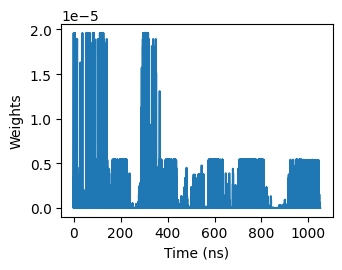

In [18]:
# find the indices
x_indx = np.digitize(ld1, ld1_grids, right=True)
y_indx = np.digitize(dihedral, dihedral_grids, right=True)

kbt=0.616033 # in kcal/mol unit

weights = np.empty(time.shape[0])
for i in range(time.shape[0]):
    weights[i] = np.exp(-fe_state_final.T[x_indx[i], y_indx[i]]/kbt)
    
weights /= np.sum(weights)

plt.figure(figsize=(3.5,2.5))
plt.xlabel("Time (ns)")
plt.ylabel("Weights")
plt.plot(time, weights)

In [19]:
print(trajData.shape)
print(weights[::50].shape)

(21001, 375, 3)
(21001,)


## n_clusters =2 

In [20]:
wsgmm = scripts.sgmm_fit_with_attempts(trajData, 2, 20, weights[::50], device=torch.device("cuda:0"), dtype=torch.float64)

Number of training frames: 21001
Number of clusters: 2
Number of attempts: 20
 Attempt  Log Like per Frame    CPU Time (s)
--------------------------------------------------
       1            1033.908           7.761
       2            1022.375           7.739
       3            1032.034           5.742
       4            1033.157           5.755
       5            1031.373           5.804
       6            1034.994           5.928
       7            1012.272           8.255
       8            1003.983           8.601
       9            1008.154           9.515
      10            1034.966           5.791
      11            1016.820           8.516
      12             969.784           6.790
      13            1027.439           6.227
      14            1006.065           9.193
      15            1035.098           6.095
      16            1032.942           6.058
      17            1031.993           5.922
      18            1032.315           5.909
      19        

In [21]:
with open("wsgmm_2state_fbias_weights.pickle", 'wb') as f:
    pickle.dump(wsgmm, f)

In [22]:
with open("wsgmm_2state_fbias_weights.pickle", "rb") as f:
    wsgmm2 = pickle.load(f)

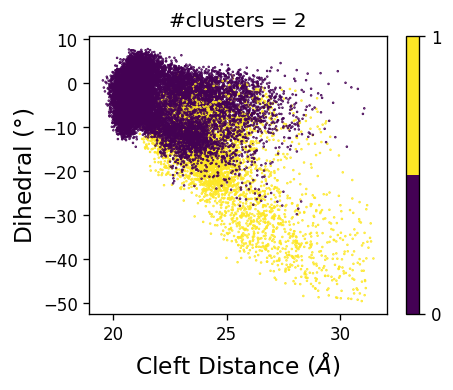

In [23]:
from matplotlib.colors import ListedColormap
color_values = np.unique(wsgmm2.cluster_ids)
cmap = plt.get_cmap("viridis", len(color_values))
custom_cmap = ListedColormap(cmap(color_values))

# plot
plt.figure(figsize=(4,3), dpi=120)
plt.title("#clusters = 2")
plt.xlabel("Cleft Distance ($\\AA$)", fontsize=14)
plt.ylabel("Dihedral ($\\degree$)", fontsize=14)
plt.scatter(cleft_dist[::50]*10, dihedral[::50]*180/3.14, c=wsgmm2.cluster_ids, marker=".", cmap=custom_cmap, s=1.0)
cbar = plt.colorbar(ticks=color_values)

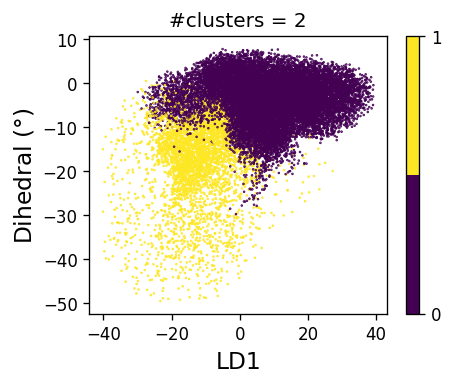

In [24]:
from matplotlib.colors import ListedColormap
color_values = np.unique(wsgmm2.cluster_ids)
cmap = plt.get_cmap("viridis", len(color_values))
custom_cmap = ListedColormap(cmap(color_values))

# plot
plt.figure(figsize=(4,3), dpi=120)
plt.title("#clusters = 2")
plt.xlabel("LD1", fontsize=14)
plt.ylabel("Dihedral ($\\degree$)", fontsize=14)
plt.scatter(ld1[::50], dihedral[::50]*180/3.14, c=wsgmm2.cluster_ids, marker=".", cmap=custom_cmap, s=1.0)
cbar = plt.colorbar(ticks=color_values)

## n_clusters = 3 

In [25]:
wsgmm = scripts.sgmm_fit_with_attempts(trajData, 3, 20, weights[::50], device=torch.device("cuda:0"), dtype=torch.float64)

Number of training frames: 21001
Number of clusters: 3
Number of attempts: 20
 Attempt  Log Like per Frame    CPU Time (s)
--------------------------------------------------
       1            1066.778           6.741
       2            1073.177           8.732
       3            1058.716           8.063
       4            1061.512           8.085
       5            1036.859           8.703
       6            1026.613          11.235
       7            1054.749           6.525
       8            1031.019           6.733
       9            1044.502           6.921
      10            1057.554           9.402
      11            1060.050          10.634
      12            1065.527           7.874
      13            1045.778          10.170
      14            1061.694           7.847
      15            1069.696           8.982
      16            1049.555          10.587
      17            1060.590          10.786
      18            1049.504          10.995
      19        

In [26]:
with open("wsgmm_3state_fbias_weights.pickle", 'wb') as f:
    pickle.dump(wsgmm, f)

In [27]:
with open("wsgmm_3state_fbias_weights.pickle", "rb") as f:
    wsgmm3 = pickle.load(f)

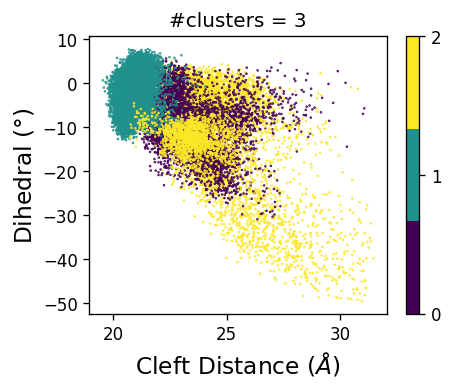

In [28]:
from matplotlib.colors import ListedColormap
color_values = np.unique(wsgmm3.cluster_ids)
cmap = plt.get_cmap("viridis", len(color_values))
custom_cmap = ListedColormap(cmap(color_values))

# plot
plt.figure(figsize=(4,3), dpi=120)
plt.title("#clusters = 3")
plt.xlabel("Cleft Distance ($\\AA$)", fontsize=14)
plt.ylabel("Dihedral ($\\degree$)", fontsize=14)
plt.scatter(cleft_dist[::50]*10, dihedral[::50]*180/3.14, c=wsgmm3.cluster_ids, marker=".", cmap=custom_cmap, s=1.0)
cbar = plt.colorbar(ticks=color_values)

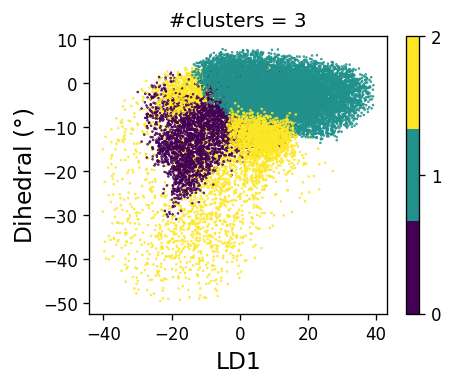

In [29]:
from matplotlib.colors import ListedColormap
color_values = np.unique(wsgmm3.cluster_ids)
cmap = plt.get_cmap("viridis", len(color_values))
custom_cmap = ListedColormap(cmap(color_values))

# plot
plt.figure(figsize=(4,3), dpi=120)
plt.title("#clusters = 3")
plt.xlabel("LD1", fontsize=14)
plt.ylabel("Dihedral ($\\degree$)", fontsize=14)
plt.scatter(ld1[::50], dihedral[::50]*180/3.14, c=wsgmm3.cluster_ids, marker=".", cmap=custom_cmap, s=1.0)
cbar = plt.colorbar(ticks=color_values)

## n_clusters = 4

In [30]:
wsgmm = scripts.sgmm_fit_with_attempts(trajData, 4, 20, weights[::50], device=torch.device("cuda:0"), dtype=torch.float64)

Number of training frames: 21001
Number of clusters: 4
Number of attempts: 20
 Attempt  Log Like per Frame    CPU Time (s)
--------------------------------------------------
       1            1053.708          10.345
       2            1090.583          15.289
       3            1020.697          11.950
       4            1093.475          13.398
       5            1046.794           8.857
       6            1054.157          11.551
       7            1097.660          11.887
       8            1081.508           8.902
       9            1064.865          11.529
      10            1095.145          11.409
      11            1076.682          13.163
      12            1054.760           9.475
      13            1082.023          11.836
      14            1082.910          10.571
      15            1068.667          13.324
      16            1050.871           7.954
      17            1038.473          10.078
      18            1063.299           9.620
      19        

In [31]:
with open("wsgmm_4state_fbias_weights.pickle", 'wb') as f:
    pickle.dump(wsgmm, f)

In [32]:
with open("wsgmm_4state_fbias_weights.pickle", "rb") as f:
    wsgmm4 = pickle.load(f)

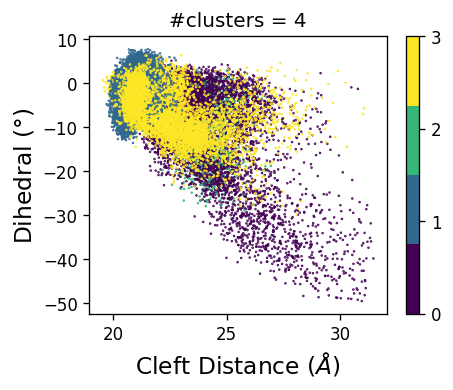

In [33]:
from matplotlib.colors import ListedColormap
color_values = np.unique(wsgmm4.cluster_ids)
cmap = plt.get_cmap("viridis", len(color_values))
custom_cmap = ListedColormap(cmap(color_values))

# plot
plt.figure(figsize=(4,3), dpi=120)
plt.title("#clusters = 4")
plt.xlabel("Cleft Distance ($\\AA$)", fontsize=14)
plt.ylabel("Dihedral ($\\degree$)", fontsize=14)
plt.scatter(cleft_dist[::50]*10, dihedral[::50]*180/3.14, c=wsgmm4.cluster_ids, marker=".", cmap=custom_cmap, s=1.0)
cbar = plt.colorbar(ticks=color_values)

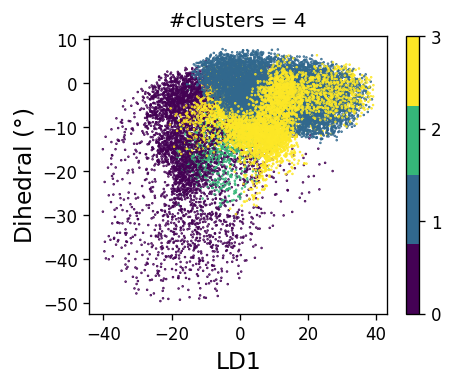

In [34]:
from matplotlib.colors import ListedColormap
color_values = np.unique(wsgmm4.cluster_ids)
cmap = plt.get_cmap("viridis", len(color_values))
custom_cmap = ListedColormap(cmap(color_values))

# plot
plt.figure(figsize=(4,3), dpi=120)
plt.title("#clusters = 4")
plt.xlabel("LD1", fontsize=14)
plt.ylabel("Dihedral ($\\degree$)", fontsize=14)
plt.scatter(ld1[::50], dihedral[::50]*180/3.14, c=wsgmm4.cluster_ids, marker=".", cmap=custom_cmap, s=1.0)
cbar = plt.colorbar(ticks=color_values)

## n_clusters = 5

In [35]:
wsgmm = scripts.sgmm_fit_with_attempts(trajData, 5, 20, weights[::50], device=torch.device("cuda:0"), dtype=torch.float64)

Number of training frames: 21001
Number of clusters: 5
Number of attempts: 20
 Attempt  Log Like per Frame    CPU Time (s)
--------------------------------------------------
       1            1079.634          17.354
       2            1060.879          12.850
       3            1099.641           9.588
       4            1086.057          10.112
       5            1080.545          12.267
       6            1105.320           9.113
       7            1107.716          12.542
       8            1117.305          13.814
       9            1091.205          15.342
      10            1095.214          10.737
      11            1083.433          13.052
      12            1106.383          12.130
      13            1041.309          13.359
      14            1112.235          14.854
      15            1105.862          14.575
      16            1072.744          13.734
      17            1108.224          12.141
      18            1104.182          10.734
      19        

In [36]:
with open("wsgmm_5state_fbias_weights.pickle", 'wb') as f:
    pickle.dump(wsgmm, f)

In [37]:
with open("wsgmm_5state_fbias_weights.pickle", "rb") as f:
    wsgmm5 = pickle.load(f)

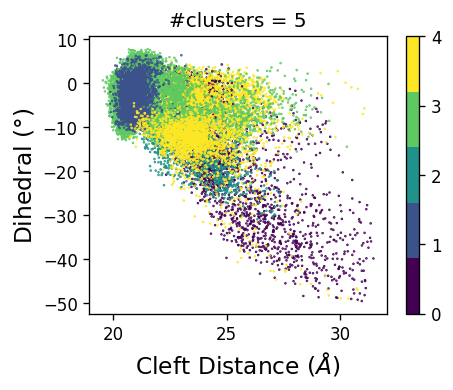

In [38]:
from matplotlib.colors import ListedColormap
color_values = np.unique(wsgmm5.cluster_ids)
cmap = plt.get_cmap("viridis", len(color_values))
custom_cmap = ListedColormap(cmap(color_values))

# plot
plt.figure(figsize=(4,3), dpi=120)
plt.title("#clusters = 5")
plt.xlabel("Cleft Distance ($\\AA$)", fontsize=14)
plt.ylabel("Dihedral ($\\degree$)", fontsize=14)
plt.scatter(cleft_dist[::50]*10, dihedral[::50]*180/3.14, c=wsgmm5.cluster_ids, marker=".", cmap=custom_cmap, s=1.0)
cbar = plt.colorbar(ticks=color_values)

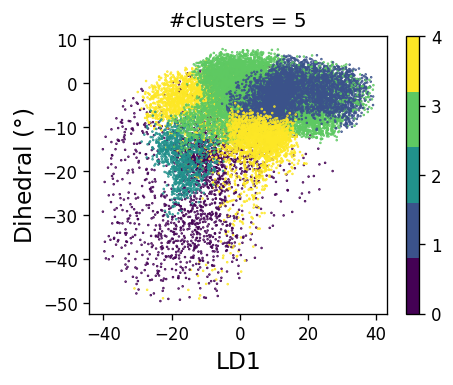

In [39]:
from matplotlib.colors import ListedColormap
color_values = np.unique(wsgmm5.cluster_ids)
cmap = plt.get_cmap("viridis", len(color_values))
custom_cmap = ListedColormap(cmap(color_values))

# plot
plt.figure(figsize=(4,3), dpi=120)
plt.title("#clusters = 5")
plt.xlabel("LD1", fontsize=14)
plt.ylabel("Dihedral ($\\degree$)", fontsize=14)
plt.scatter(ld1[::50], dihedral[::50]*180/3.14, c=wsgmm5.cluster_ids, marker=".", cmap=custom_cmap, s=1.0)
cbar = plt.colorbar(ticks=color_values)